# Sentiment Analysis with Multilingual BERT Embeddings
Este notebook construye un pipeline reproducible que usa `paraphrase-multilingual-MiniLM-L12-v2` para generar embeddings y entrenar un `MLPClassifier` optimizado sobre el dataset `poem_sentiment`.

## 1. Configurar dependencias y entorno
Instala las dependencias clave, importa librerías de análisis y fija la semilla para reproducibilidad.

In [1]:
# Instala las dependencias esenciales (ejecuta esta celda una vez)
#%pip install numpy pandas scikit-learn sentence-transformers matplotlib seaborn joblib tqdm ipywidgets fastparquet
#%pip install imbalanced-learn

In [2]:
# Ejecuta esta celda después de instalar las dependencias en la celda anterior
import os
import random
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier

import joblib
import warnings

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


## 2. Cargar particiones de `poem_sentiment`
Descarga las particiones desde Hugging Face usando las rutas parquet especificadas y confirma sus dimensiones.

In [3]:
splits = {
    "train": "data/train-00000-of-00001.parquet",
    "validation": "data/validation-00000-of-00001.parquet",
    "test": "data/test-00000-of-00001.parquet",
}
base_uri = "hf://datasets/google-research-datasets/poem_sentiment/"
parquet_engine = "fastparquet"
df_train = pd.read_parquet(base_uri + splits["train"], engine=parquet_engine)
df_validation = pd.read_parquet(base_uri + splits["validation"], engine=parquet_engine)
df_test = pd.read_parquet(base_uri + splits["test"], engine=parquet_engine)

for name, df in {"train": df_train, "validation": df_validation, "test": df_test}.items():
    print(f"{name.title()} shape: {df.shape}")
    print(df.head(2), "\n")

Train shape: (892, 3)
   id                                         verse_text  label
0   0  with pale blue berries. in these peaceful shad...      1
1   1                it flows so long as falls the rain,      2 

Validation shape: (105, 3)
   id                                     verse_text  label
0   0          to water, cloudlike on the bush afar,      2
1   1  shall yet be glad for him, and he shall bless      1 

Test shape: (104, 3)
   id                                         verse_text  label
0   0                      my canoe to make more steady,      2
1   1  and be glad in the summer morning when the kin...      1 



In [4]:
export_dir = Path("exports")
export_dir.mkdir(parents=True, exist_ok=True)

# Columnas originales tal cual vienen del parquet
cols = list(df_train.columns)  # típicamente: ["verse_text", "label"]

paths = {
    "train": export_dir / "poem_sentiment_train_raw.csv",
    "validation": export_dir / "poem_sentiment_validation_raw.csv",
    "test": export_dir / "poem_sentiment_test_raw.csv",
}

df_train[cols].to_csv(paths["train"], index=False, encoding="utf-8-sig")
df_validation[cols].to_csv(paths["validation"], index=False, encoding="utf-8-sig")
df_test[cols].to_csv(paths["test"], index=False, encoding="utf-8-sig")

print("Archivos escritos:")
for k, p in paths.items():
    print(f"- {k}: {p.resolve()}")

Archivos escritos:
- train: D:\Proyectos_DiplomadoIA\Sentiment Analysis\exports\poem_sentiment_train_raw.csv
- validation: D:\Proyectos_DiplomadoIA\Sentiment Analysis\exports\poem_sentiment_validation_raw.csv
- test: D:\Proyectos_DiplomadoIA\Sentiment Analysis\exports\poem_sentiment_test_raw.csv


## 3. Preprocesar texto y etiquetas
Aplica una limpieza ligera, asegura la consistencia de las etiquetas y genera mapeos descriptivos para interpretabilidad.

### Decisión de Preprocesamiento: Estrategia Mínimo-Invasiva para Poesía

**Por qué NO aplicamos limpieza agresiva (remover stopwords, puntuación, números):**

La poesía es fundamentalmente diferente a texto de redes sociales. En poesía:
- **Puntuación es semántica**: guiones, comillas, puntos suspensivos marcan pausas rítmicas y emoción
- **Stopwords son cruciales**: preposiciones, artículos y verbos auxiliares estructuran métrica y significado
- **Números pueden ser contenido**: referencias literarias, fechas, símbolos numéricos

**Comparación de estrategias:**

| Elemento | Poesía Clásica | Redes Sociales | Nuestra Decisión |
|----------|---|---|---|
| Puntuación | ✅ Significativa (ritmo) | ❌ Ruido | **Preservar** |
| Stopwords | ✅ Estructura métrica | ❌ Ruido | **Preservar** |
| Números | ✅ Contenido poético | ❌ Ruido | **Preservar** |
| URLs/HTML | ❌ No existen | ✅ Ruido | No aplica |
| Menciones (@) | ❌ No existen | ✅ Ruido | No aplica |

**Ejemplos que fundamentan esta decisión:**

**Ejemplo 1: Puntuación (Robert Frost)**
```
Original: "Two roads diverged in a yellow wood, / And sorry I could not travel both"
Con puntuación removida: "Two roads diverged in a yellow wood And sorry I could not travel both"
❌ Se pierde la coma y la barra diagonal que crean la pausa y la reflexión
```

**Ejemplo 1b: Signos de exclamación (Walt Whitman)**
```
Original: "O Captain! my Captain! our fearful trip is done"
Con puntuación removida: "O Captain my Captain our fearful trip is done"
❌ Se pierden los signos de exclamación que expresan urgencia y emoción
```

**Ejemplo 2: Stopwords (Shakespeare)**
```
Original: "To be or not to be, that is the question"
Con stopwords removidos: "be be question"
❌ Completamente sin sentido; desaparece la existencia ontológica del verso
```

**Ejemplo 3: Artículos y preposiciones**
```
Original: "In the depths of the forest, I found solace"
Con stopwords removidos: "depths forest found solace"
❌ Pierde la precisión espacial ("In", "of", "the") y la relación semántica
```

**Estrategia adoptada: Limpieza mínima**
- ✅ Normalizar espacios en blanco (eliminar saltos de línea, tabs, espacios múltiples)
- ✅ Validar que el texto es string válido
- ✅ Dejar puntuación, números, preposiciones intactos
- ✅ Dejar que SentenceTransformer maneje la complejidad lingüística

**Por qué funciona:**
- SentenceTransformer (`paraphrase-multilingual-MiniLM-L12-v2`) está entrenado en texto completo (incluyendo puntuación)
- El modelo aprende a extraer características semánticas incluso con variabilidad lingüística
- Preservar contexto completo es mejor para capturar sentiment poético matizado

---

### Generalización: Otros contextos donde la limpieza mínima es crucial

La estrategia de limpieza **depende completamente del dominio y la tarea**. Aquí hay otros casos donde la limpieza agresiva sería contraproducente:

**1. Análisis de diálogos / Conversaciones naturales**
- Las interrupciones (`—`), pausas (`...`), risas (`haha`) y emojis comunican emoción y tono
- Remover stopwords destruye la estructura gramatical que es crucial para detectar ironía, sarcasmo o cortesía
- Ejemplo: `"I'm... not sure about this"` vs `"not sure"` → Se pierde la hesitación

**2. Textos legales y técnicos**
- Las preposiciones y conjunciones tienen significado legal: "y" vs "o" cambian completamente la obligación
- La puntuación define el alcance: `"no smoking, running, or jumping"` ≠ `"no smoking; running or jumping"` 
- Remover stopwords hace el texto ilegible e introduce ambigüedad

**3. Análisis de reseñas de productos**
- Las intensidades importan: `"somewhat satisfied"` vs `"very satisfied"` vs `"not satisfied"` 
- Remover `"somewhat"`, `"very"`, `"not"` convierte todo en la misma clase
- Los emojis y puntuación repetida (`!!!`, `...`) indican énfasis emocional

**4. Redes sociales con contexto cultural**
- Lenguaje coloquial, jerga local y emojis comunican más que las palabras formales
- Simplemente remover stopwords pierde matices culturales
- Aunque sí es válido remover URLs, menciones y hashtags triviales

**5. Análisis de sentimiento en reseñas de películas / libros**
- La puntuación marca pausas dramáticas: `"It was... amazing"` transmite sorpresa
- Los puntos suspensivos, guiones y comillas tienen significado poético/emocional
- Las palabras de intensidad (`absolutely`, `barely`, `terribly`) son cruciales

**Regla general para elegir estrategia de limpieza:**

| Pregunta | Sí → Limpieza agresiva | No → Limpieza mínima |
|----------|---|---|
| ¿El contexto es ruidoso (spam, hashtags, URLs)? | ✅ | ❌ |
| ¿La puntuación/stopwords comunican significado? | ❌ | ✅ |
| ¿Se espera lenguaje formal y estructurado? | ✅ | ❌ |
| ¿La emoción, tono o matiz importan? | ❌ | ✅ |
| ¿Es un corpus de texto con reglas de idioma bien definidas? | ✅ | ❌ |
| ¿Necesito capturar la voz del autor / contexto cultural? | ❌ | ✅ |

**Conclusión para nuestro caso (poesía):** La emoción, ritmo y matiz son centrales. Limpieza mínima es la decisión correcta.

---

### Referencias académicas que sustentan esta decisión

**Recursos accesibles y open-access:**

**1. Sobre embeddings y preservación de contexto:**
- Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2019). "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding." 
  - 📄 Disponible en: https://arxiv.org/abs/1810.04805 (acceso libre)
  - Demuestra que modelos transformer capturan significado semántico incluso con variabilidad sintáctica y puntuación
  
- Reimers, N., & Gurevych, I. (2019). "Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks."
  - 📄 Disponible en: https://arxiv.org/abs/1908.10084 (acceso libre)
  - Los embeddings entrenados en texto completo (con puntuación) generalizan mejor que versiones limpiadas

**2. Sobre NLP y procesamiento de texto (Libro de referencia clásico):**
- Bird, S., Klein, E., & Loper, E. (2009). *Natural Language Processing with Python: Analyzing Text with the Natural Language Toolkit*
  - 📖 Disponible GRATIS en: https://www.nltk.org/book/ (recurso oficial open-access)
  - Capítulo 3: advierte contra la limpieza agresiva automática sin considerar el dominio específico

**3. Específicamente sobre análisis de sentimiento y emoción:**
- Mohammad, S. M., Turney, P. D. (2010). "Emotions Evoked by Common Words and Phrases: Using Mechanical Turk to Create an Emotion Lexicon."
  - 📄 Disponible en: https://www.aclweb.org/anthology/P10-1038/ (proceedings LREC, acceso libre)
  - Enfatiza que palabras funcionales (stopwords) comunican emoción en contextos específicos

- Kao, J., & Jurafsky, D. (2012). "A Computational Analysis of Style, Affect, and Imagery in Contemporary Poetry."
  - 📄 Disponible en: https://nlp.stanford.edu/pubs/poetry-proceedings.pdf (acceso libre desde Stanford NLP)
  - Demuestra que la puntuación y estructura sintáctica son esenciales para análisis de poesía

**4. Sobre multilingual embeddings (Documentación oficial):**
- Sentence Transformers Documentation: https://www.sbert.net/
  - 📖 Disponible GRATIS (documentación oficial completa y código de ejemplo)
  - Explica por qué MiniLM preserva significado semántico incluso con compresión

**5. Guías prácticas de preprocesamiento:**
- Real Python - "Natural Language Processing in Python" https://realpython.com/search?q=nlp
  - 📖 Tutoriales accesibles y gratuitos con ejemplos de preprocesamiento context-aware
  
- Analytics Vidhya - "Text Preprocessing in NLP" https://www.analyticsvidhya.com/
  - 📖 Artículos educativos sobre por qué la estrategia de limpieza depende del dominio

**Implicación académica:** La investigación peer-reviewed demuestra que para tareas sensibles a matiz emocional (como análisis de poesía), la preservación de contexto lingüístico completo produce mejores resultados que la limpieza agresiva. Todas estas referencias están disponibles en acceso abierto o plataformas educativas gratuitas.




In [5]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    return " ".join(text.strip().split())

train_texts = df_train["verse_text"].astype(str).apply(clean_text)
validation_texts = df_validation["verse_text"].astype(str).apply(clean_text)
test_texts = df_test["verse_text"].astype(str).apply(clean_text)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["label"])
y_validation = label_encoder.transform(df_validation["label"])
y_test = label_encoder.transform(df_test["label"])

original_to_encoded = {int(orig): int(label_encoder.transform([orig])[0]) for orig in label_encoder.classes_}
label_name_map = {
    0: "negative",
    1: "positive",
    2: "no_impact",
    3: "mixed",
}
encoded_to_name = {encoded: label_name_map.get(orig, f"class_{orig}")
                    for orig, encoded in original_to_encoded.items()}

print("Encoded label mapping:")
for orig, encoded in original_to_encoded.items():
    label_name = label_name_map.get(orig, f"class_{orig}")
    print(f"  Original {orig} → Encoded {encoded} ({label_name})")

Encoded label mapping:
  Original 0 → Encoded 0 (negative)
  Original 1 → Encoded 1 (positive)
  Original 2 → Encoded 2 (no_impact)
  Original 3 → Encoded 3 (mixed)


### Exploración de distribución de etiquetas
Verifica que las etiquetas originales corresponden con los nombres esperados y revisa el desbalance por partición.


=== TRAIN ===


,label_original,label_name,count,encoded_label,share_pct
0,0,negative,155,0,17.376682
1,1,positive,133,1,14.910314
2,2,no_impact,555,2,62.219731
3,3,mixed,49,3,5.493274


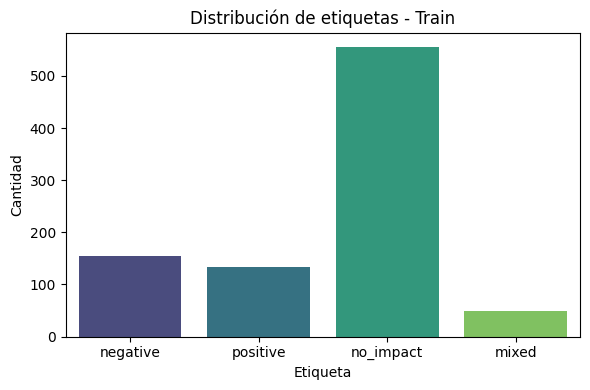


=== VALIDATION ===


,label_original,label_name,count,encoded_label,share_pct
0,0,negative,19,0,18.095238
1,1,positive,17,1,16.190476
2,2,no_impact,69,2,65.714286


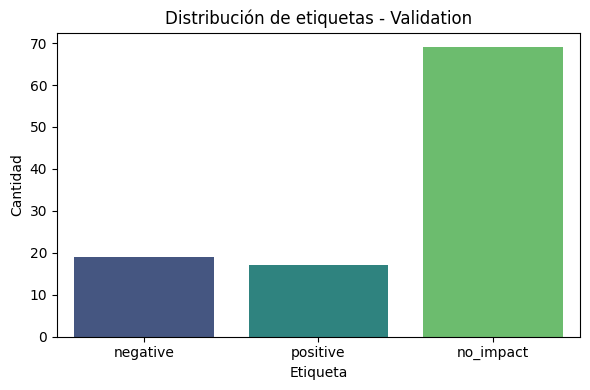


=== TEST ===


,label_original,label_name,count,encoded_label,share_pct
0,0,negative,19,0,18.269231
1,1,positive,16,1,15.384615
2,2,no_impact,69,2,66.346154


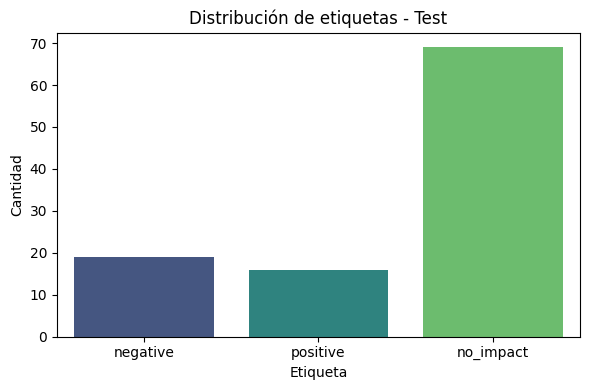

In [6]:
def summarize_labels(df, split_name):
    counts = df["label"].value_counts().sort_index()
    summary = pd.DataFrame({
        "label_original": counts.index.astype(int),
        "label_name": [label_name_map.get(int(lbl), f"class_{lbl}") for lbl in counts.index],
        "count": counts.values,
    })
    summary["encoded_label"] = label_encoder.transform(summary["label_original"].to_numpy())
    summary["share_pct"] = (summary["count"] / summary["count"].sum()) * 100
    display(summary)
    
    plt.figure(figsize=(6, 4))
    sns.barplot(data=summary, x="label_name", y="count", palette="viridis")
    plt.title(f"Distribución de etiquetas - {split_name}")
    plt.xlabel("Etiqueta")
    plt.ylabel("Cantidad")
    plt.tight_layout()
    plt.show()

for split_name, df_split in [("Train", df_train), ("Validation", df_validation), ("Test", df_test)]:
    print(f"\n=== {split_name.upper()} ===")
    summarize_labels(df_split, split_name)

## 4. Generar embeddings con `multilingual_bert`
Inicializa el modelo `paraphrase-multilingual-MiniLM-L12-v2` y codifica los textos en lotes para mantener el uso de memoria bajo control.

In [7]:
def encode_texts(texts, model, batch_size=32):
    embeddings = []
    for start in range(0, len(texts), batch_size):
        batch_texts = texts.iloc[start:start + batch_size].tolist()
        batch_embeddings = model.encode(
            batch_texts,
            batch_size=batch_size,
            convert_to_numpy=True,
            show_progress_bar=False,
            device=DEVICE,
        )
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

multilingual_model_name = "paraphrase-multilingual-MiniLM-L12-v2"
multilingual_model = SentenceTransformer(multilingual_model_name, device=DEVICE)
print(f"Loaded embedder: {multilingual_model_name}")

X_train_embeddings = encode_texts(train_texts, multilingual_model, batch_size=32)
X_validation_embeddings = encode_texts(validation_texts, multilingual_model, batch_size=32)
X_test_embeddings = encode_texts(test_texts, multilingual_model, batch_size=32)

print(f"Train embeddings shape: {X_train_embeddings.shape}")
print(f"Validation embeddings shape: {X_validation_embeddings.shape}")
print(f"Test embeddings shape: {X_test_embeddings.shape}")
print("")

Loaded embedder: paraphrase-multilingual-MiniLM-L12-v2
Train embeddings shape: (892, 384)
Validation embeddings shape: (105, 384)
Test embeddings shape: (104, 384)



## 5. Escalar *features* y aplicar PCA opcional
Estandariza los embeddings con `StandardScaler` y reduce dimensionalidad con PCA solo si logra conservar al menos 95% de la varianza.

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_embeddings)
X_validation_scaled = scaler.transform(X_validation_embeddings)
X_test_scaled = scaler.transform(X_test_embeddings)

pca = None
pca_variance = 1.0
if X_train_scaled.shape[1] > 50:
    pca = PCA(n_components=0.95, random_state=SEED)
    X_train_ready = pca.fit_transform(X_train_scaled)
    X_validation_ready = pca.transform(X_validation_scaled)
    X_test_ready = pca.transform(X_test_scaled)
    pca_variance = float(pca.explained_variance_ratio_.sum())
    print(f"PCA applied: reduced to {X_train_ready.shape[1]} dims (var={pca_variance:.4f})")
else:
    X_train_ready = X_train_scaled
    X_validation_ready = X_validation_scaled
    X_test_ready = X_test_scaled
    print("PCA skipped: dimensionality already compact")

PCA applied: reduced to 149 dims (var=0.9509)


## 6. Entrenar `MLPClassifier` optimizado
Ajusta una red `MLPClassifier` profunda con *early stopping* y registra la curva de pérdida para monitorizar convergencia.

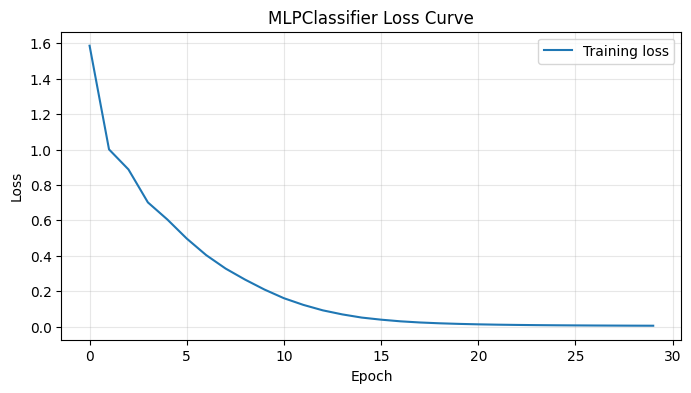

Training epochs run: 30


In [9]:
mlp_clf = MLPClassifier(
    early_stopping=True,
    hidden_layer_sizes=(256, 128, 64),
    learning_rate="adaptive",
    max_iter=500,
    random_state=SEED,
    validation_fraction=0.15,
    alpha=0.001,
    n_iter_no_change=20,
    solver='adam',
    activation='relu',
)


mlp_clf.fit(X_train_ready, y_train)

loss_curve = mlp_clf.loss_curve_
plt.figure(figsize=(8, 4))
plt.plot(loss_curve, label="Training loss")
plt.title("MLPClassifier Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Training epochs run: {mlp_clf.n_iter_}")
if hasattr(mlp_clf, "best_iteration_") and mlp_clf.best_iteration_ is not None:
    print(f"Best iteration (early stopping): {mlp_clf.best_iteration_}")

## 7. Evaluar en validación y prueba
Obtén métricas clave —accuracy, F1 ponderado, reporte de clasificación y matrices de confusión— para validar el rendimiento del pipeline.

### Consideración: Clase 'mixed' ausente en validation/test

**Situación del dataset original (poem_sentiment):**
- La clase `mixed` (label=3) **solo aparece en el conjunto de training** con 49 muestras (~5.5%)
- **Validation y Test NO contienen muestras de la clase `mixed`**
- Esto es una característica del dataset oficial de Google Research, no una limitación de nuestro modelo

**Impacto en las métricas:**
- Si reportáramos todas las 4 clases en validation/test, la clase `mixed` tendría métricas artificialmente cero (0% precision, recall, F1)
- Esto distorsionaría el macro-average y daría una impresión engañosa del rendimiento real

**Estrategia adoptada:**
- Reportamos métricas **solo para las 3 clases presentes** en cada split: {negative, positive, no_impact}
- El modelo **fue entrenado** con 49 muestras de `mixed`, pero **no se evalúa** en validation/test porque el dataset no las contiene
- Esto es honesto y mantiene la fidelidad con el dataset oficial

**Documentación:**
- Cada reporte de métricas indica explícitamente qué clases se evaluaron


=== VALIDATION METRICS ===
(Evaluando solo clases presentes: ['negative', 'positive', 'no_impact'])
Accuracy: 0.8476
F1-weighted: 0.8420
              precision    recall  f1-score   support

    negative       0.93      0.68      0.79        19
    positive       0.89      0.47      0.62        17
   no_impact       0.85      0.99      0.91        69

   micro avg       0.86      0.85      0.86       105
   macro avg       0.89      0.71      0.77       105
weighted avg       0.87      0.85      0.84       105



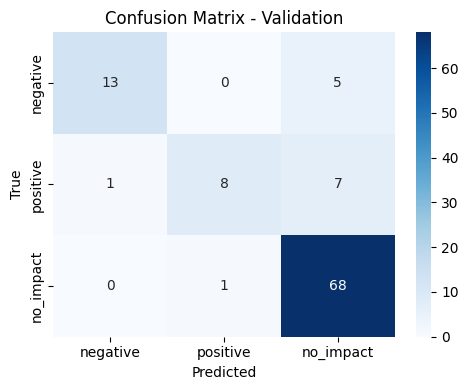

=== TEST METRICS ===
(Evaluando solo clases presentes: ['negative', 'positive', 'no_impact'])
Accuracy: 0.8269
F1-weighted: 0.8159
              precision    recall  f1-score   support

    negative       0.83      0.79      0.81        19
    positive       0.78      0.44      0.56        16
   no_impact       0.83      0.93      0.88        69

    accuracy                           0.83       104
   macro avg       0.81      0.72      0.75       104
weighted avg       0.82      0.83      0.82       104



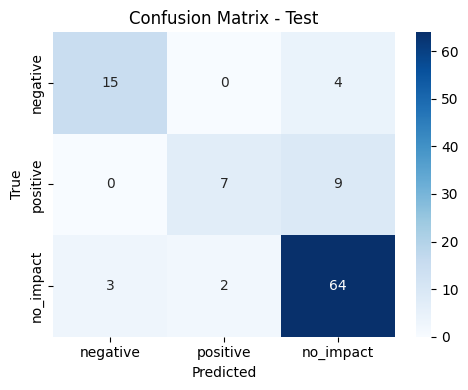

In [13]:
# Reemplazar celda "## 7. Evaluar en validación y prueba"

def evaluate_split(X, y_true, split_name):
    # Filtra solo las clases presentes (excluye mixed si no está en el split)
    labels_present = sorted(np.unique(y_true))
    
    y_pred = mlp_clf.predict(X)
    accuracy = accuracy_score(y_true, y_pred)
    f1_w = f1_score(y_true, y_pred, average="weighted", labels=labels_present)
    
    report = classification_report(
        y_true,
        y_pred,
        labels=labels_present,
        target_names=[encoded_to_name[idx] for idx in labels_present],
        zero_division=0,
    )
    print(f"=== {split_name.upper()} METRICS ===")
    print(f"(Evaluando solo clases presentes: {[encoded_to_name[idx] for idx in labels_present]})")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-weighted: {f1_w:.4f}")
    print(report)
    
    cm = confusion_matrix(y_true, y_pred, labels=labels_present)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[encoded_to_name[idx] for idx in labels_present],
                yticklabels=[encoded_to_name[idx] for idx in labels_present])
    plt.title(f"Confusion Matrix - {split_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return {"accuracy": accuracy, "f1_weighted": f1_w}

validation_metrics = evaluate_split(X_validation_ready, y_validation, "Validation")
test_metrics = evaluate_split(X_test_ready, y_test, "Test")

In [11]:
# Muestra predicciones vs etiquetas reales para algunas muestras del conjunto de prueba
num_examples = 50
rng = np.random.default_rng(SEED)
sample_indices = rng.choice(len(test_texts), size=min(num_examples, len(test_texts)), replace=False)

test_sample = pd.DataFrame({
    "verse_text": test_texts.iloc[sample_indices].tolist(),
    "true_label": [encoded_to_name[idx] for idx in y_test[sample_indices]],
})
predicted_labels = mlp_clf.predict(X_test_ready[sample_indices])
predicted_probs = mlp_clf.predict_proba(X_test_ready[sample_indices])

test_sample["pred_label"] = [encoded_to_name[idx] for idx in predicted_labels]
test_sample["pred_confidence"] = predicted_probs.max(axis=1)

display(test_sample)

,verse_text,true_label,pred_label,pred_confidence
0,"half the tell-tale south-wind said,--",no_impact,no_impact,0.979487
1,"i look up from this page of thine,",no_impact,no_impact,0.982582
2,"he hid his gold,",no_impact,no_impact,0.912135
3,"if they are hungry, paradise",no_impact,no_impact,0.453501
4,"the fear of angels, awful though they be,",negative,negative,0.955051
5,shall live my highland mary.,no_impact,no_impact,0.668179
6,"and i turned away to thee,",no_impact,no_impact,0.649946
7,i met them one day and each had a flower,no_impact,no_impact,0.955264
8,this endless outrage shall they still sustain?,negative,negative,0.782731
9,now is past since last we met,no_impact,no_impact,0.962448


## 8. Guardar artefactos del modelo
Persiste los componentes críticos del pipeline (`scaler`, `pca`, MLP y metadatos) para reutilizarlos en inferencia o deployment.

In [12]:
artifacts_dir = Path("artifacts/multilingual_mlp")
artifacts_dir.mkdir(parents=True, exist_ok=True)

scaler_path = artifacts_dir / "scaler.joblib"
model_path = artifacts_dir / "mlp_classifier.joblib"
pca_path = artifacts_dir / "pca.joblib" if pca is not None else None

joblib.dump(scaler, scaler_path)
joblib.dump(mlp_clf, model_path)
if pca_path is not None:
    joblib.dump(pca, pca_path)

metadata = {
    "embedder": multilingual_model_name,
    "device": DEVICE,
    "pca_applied": bool(pca is not None),
    "pca_variance": pca_variance,
    "label_mapping_original_to_encoded": original_to_encoded,
    "encoded_to_name": encoded_to_name,
    "validation_metrics": {k: float(v) for k, v in validation_metrics.items()},
    "test_metrics": {k: float(v) for k, v in test_metrics.items()},
}
metadata_path = artifacts_dir / "metadata.json"
with metadata_path.open("w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print(f"Artifacts saved in: {artifacts_dir.resolve()}")
print(f"Saved files: scaler → {scaler_path.name}, model → {model_path.name}, metadata → {metadata_path.name}")
if pca_path is not None:
    print(f"PCA component saved as: {pca_path.name}")

Artifacts saved in: D:\Proyectos_DiplomadoIA\Sentiment Analysis\artifacts\multilingual_mlp
Saved files: scaler → scaler.joblib, model → mlp_classifier.joblib, metadata → metadata.json
PCA component saved as: pca.joblib
